In [1]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt

from statsmodels.distributions.empirical_distribution import ECDF
from collections import Counter
import statsmodels.api as sm

%matplotlib inline

## Критерии согласия

### Критерий согласия Пирсона (хи-квадрат)

$H_0:$ Выборка из некоторого класса распределений

$H_1: H_0$ не верна.

<a href=https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html#scipy.stats.chisquare>`chisquare`</a>`(f_obs, f_exp=None, ddof=0)`

`f_obs` --- число элементов выборки, попавших в каждый из интервалов

`f_exp` --- ожидаемое число (по умолчанию равномерное)

`ddof` --- поправка на число степеней свободы. Статистика асимптотически будет иметь распределение $k - 1 - ddof$, где $k$ --- число интервалов.

In [3]:
sps.chisquare([16, 18, 16, 14, 12, 12])

Power_divergenceResult(statistic=2.0, pvalue=0.84914503608460956)

In [8]:
sps.chisquare([16, 18, 16, 14, 12, 12], f_exp=[16, 16, 16, 16, 20, 4])

Power_divergenceResult(statistic=19.699999999999999, pvalue=0.0014224993317060594)

Эксперимент с горохом Менделя

In [269]:
sps.chisquare([315, 101, 108, 32], f_exp=np.array([9, 3, 3, 1]) * 556/16)

Power_divergenceResult(statistic=0.47002398081534769, pvalue=0.92542589510361595)

Эксперимент с группами крови

In [272]:
sps.chisquare([121, 120, 79, 33], f_exp=np.array([0.343, 0.340, 0.224, 0.093]) * 353, ddof=2)

Power_divergenceResult(statistic=0.001011144526478114, pvalue=0.97463274380967313)

In [9]:
sps.chisquare([16, 18, 16, 14, 12, 12], f_exp=[16, 16, 16, 16, 24, 0])

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:4351: RuntimeWarning: divide by zero encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


Power_divergenceResult(statistic=inf, pvalue=0.0)

Посмотрим, насколько хорошо выполняется асимптотика при справедливости нулевой гипотезы для разных распределений.

**1.** Равномерное на 5 элементах

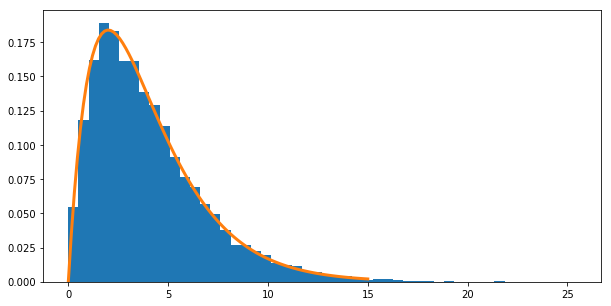

In [85]:
size = 1000
chisq_values = []

for i in range(10000):
    sample = sps.randint(low=0, high=5).rvs(size=size)
    f_obs = np.array(list(Counter(sample).values()))
    f_exp = np.array([0.2] * 5) * size
    chisq_values.append(((f_obs - f_exp)**2 / f_exp).sum())
    
plt.figure(figsize=(10, 5))
plt.hist(chisq_values, bins=50, normed=True)
grid = np.linspace(0, 15, 100)
plt.plot(grid, sps.chi2(df=4).pdf(grid), lw=3)
plt.show()

**2.** Равномерное на 4 элементах, а 5-й с очень маленькой вероятностью.

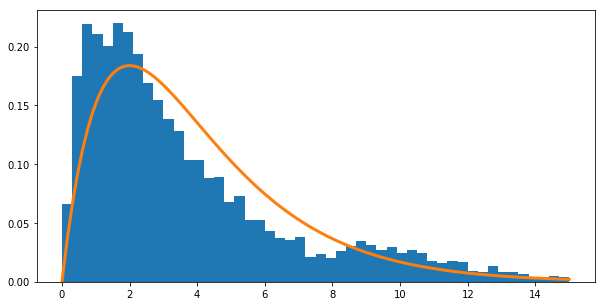

In [86]:
size = 1000
chisq_values = []

epsilon = 0.0001
pk = np.array([0.25 - epsilon / 4] * 4 + [epsilon])
some_distribution = sps.rv_discrete(name='1', values=(np.arange(5), pk))

for i in range(10000):
    sample = some_distribution.rvs(size=size)
    f_obs = np.array(list(Counter(sample).values()))
    if len(f_obs) == 4: f_obs = np.append(f_obs,[0])
    f_exp = pk * size
    chisq_values.append(((f_obs - f_exp)**2 / f_exp).sum())
    
plt.figure(figsize=(10, 5))
plt.hist(chisq_values, bins=50, normed=True, range=(0, 15))
grid = np.linspace(0, 15, 100)
plt.plot(grid, sps.chi2(df=4).pdf(grid), lw=3)
plt.show()

**Вывод:** асимптотика ломается, если есть интервалы с малой вероятностью или с малым числом элементов в выборке.

### Критерий согласия Колмогорова (-Смирнова) {для нормальных Лиллиефорса}

$H_0:$ Выборка из некоторого класса распределений

$H_1: H_0$ не верна.

<a href=https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html#scipy.stats.kstest>`kstest`</a>`(rvs, cdf, args=())`

`rvs` --- выборка

`cdf` --- функция распределения (сама функция или ее название)

`args` --- параметры распределения

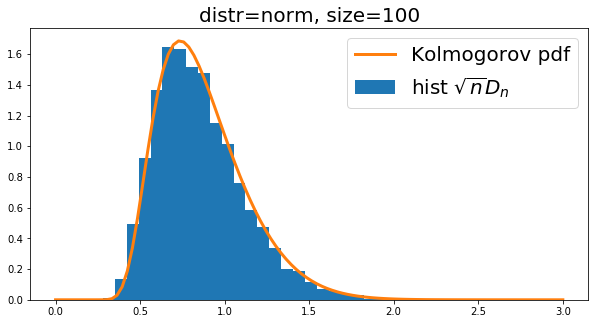

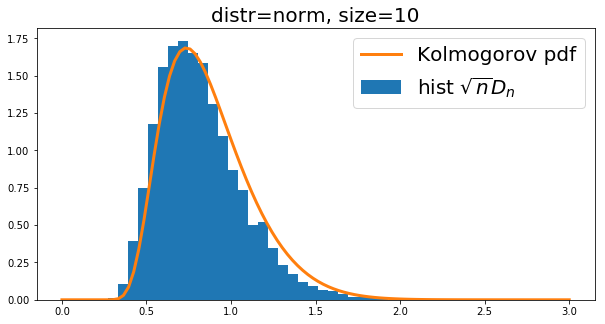

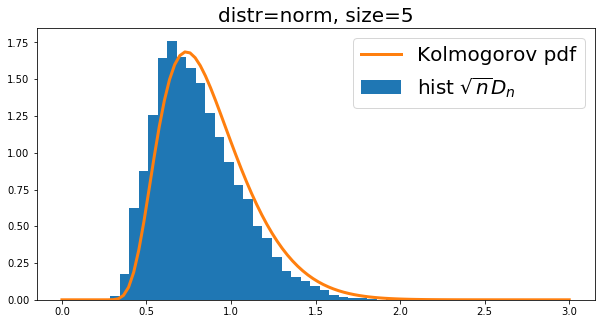

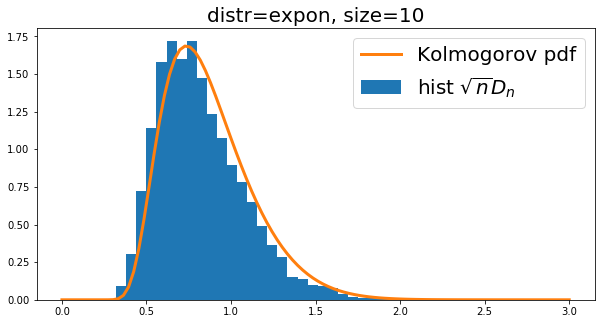

In [207]:
for size, distr in zip([100, 10, 5, 10], [sps.norm] * 3 + [sps.expon]):
    D = []
    
    for i in range(10000):
        sample = distr.rvs(size=size)
        ecdf_values = ECDF(sample)(sample)
        cdf_values = distr.cdf(sample)
        D.append(max(np.abs(ecdf_values - cdf_values).max(), 
                     np.abs(ecdf_values - 1/size - cdf_values).max()))

    plt.figure(figsize=(10, 5))
    plt.hist(np.array(D) * np.sqrt(size), bins=30, normed=True, label='hist $\\sqrt{n} D_n$')
    plt.plot(grid, sps.kstwobign.pdf(grid), lw=3, label='Kolmogorov pdf')
    plt.title('distr={}, size={}'.format(distr.name, size), fontsize=20)
    plt.legend(fontsize=20)
    plt.show()

Рассмотрим случай $H_0: \mathcal{N}(0, 1)$ 

In [129]:
def apply_kstest(sample, cdf=sps.norm.cdf):
    print(sps.kstest(sample, sps.norm.cdf))

    ecdf = ECDF(sample)
    grid = np.linspace(-3, 3, 500)

    plt.figure(figsize=(7, 3))
    plt.plot(grid, ecdf(grid), color='red', label='ecdf')
    plt.plot(grid, cdf(grid), color='blue', label='cdf')
    plt.legend()
    plt.grid(ls=':')
    plt.show()

Нулевая гипотеза верна:

KstestResult(statistic=0.078684607010999982, pvalue=0.55070855314103873)


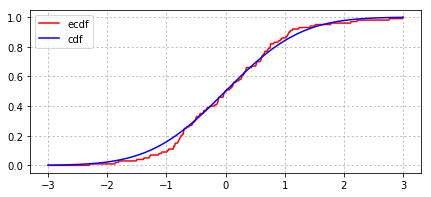

In [116]:
apply_kstest(sps.norm.rvs(size=100))

Истинное распределение - Лапласс

KstestResult(statistic=0.066549069183722387, pvalue=0.78987345421548882)


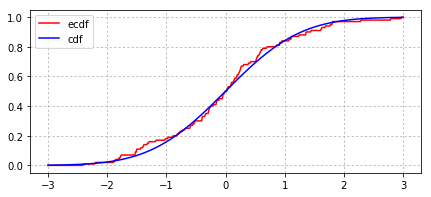

In [118]:
apply_kstest(sps.laplace.rvs(size=100))

Истинное распределение - Коши

KstestResult(statistic=0.16538604109067157, pvalue=0.0073736584430901253)


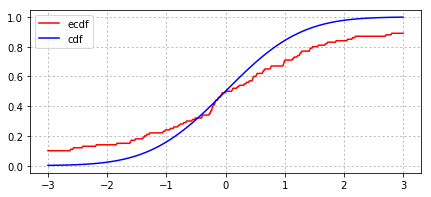

In [121]:
apply_kstest(sps.cauchy.rvs(size=100))

KstestResult(statistic=0.11098233659524928, pvalue=0.1579096638336388)


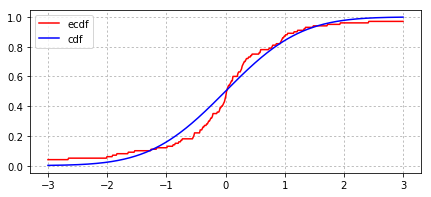

In [128]:
apply_kstest(sps.cauchy(scale=0.5).rvs(size=100))

KstestResult(statistic=0.098967003470354031, pvalue=0.26401253967536009)


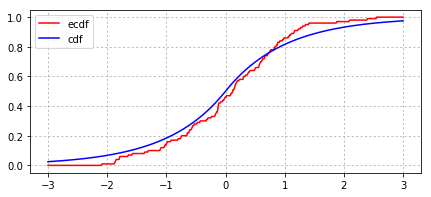

In [131]:
apply_kstest(sps.norm.rvs(size=100), cdf=sps.laplace.cdf)

**Вывод:** Критерий не чувствителен к хвостам распределений.

### Критерий Андерсона-Дарлинга

$H_0:$ Выборка из некоторого класса распределений

$H_1: H_0$ не верна.

<a href=https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.anderson.html#scipy.stats.anderson>`anderson`</a>`(x, dist='norm')`

`x` --- выборка

`dist : {'norm', 'expon', 'logistic', 'gumbel'}` --- распределение

Возвращает `(statistic, critical_values, significance_level)`. В `critical_values` записаны пороги для критериев, которым соответствуют уровни значимости из `significance_level` в процентах. То есть критерий `{statistic > critical_values[i]}` имеет уровень значимости `significance_level[i]`.

In [154]:
sample = sps.norm.rvs(size=100)
sps.anderson(sample)

AndersonResult(statistic=0.63036434210636116, critical_values=array([ 0.555,  0.632,  0.759,  0.885,  1.053]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))

In [155]:
sample = sps.laplace.rvs(size=100)
sps.anderson(sample)

AndersonResult(statistic=2.1156505395648537, critical_values=array([ 0.555,  0.632,  0.759,  0.885,  1.053]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))

In [156]:
sample = sps.cauchy.rvs(size=100)
sps.anderson(sample)

AndersonResult(statistic=21.052154555588984, critical_values=array([ 0.555,  0.632,  0.759,  0.885,  1.053]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))

In [157]:
sample = sps.norm.rvs(size=100)
sps.anderson(sample, dist='logistic')

AndersonResult(statistic=0.39496158826771932, critical_values=array([ 0.425,  0.562,  0.658,  0.767,  0.904,  1.007]), significance_level=array([ 25. ,  10. ,   5. ,   2.5,   1. ,   0.5]))

### Q-Q plot

<a href=http://statsmodels.sourceforge.net/stable/generated/statsmodels.graphics.gofplots.ProbPlot.qqplot.html?highlight=qqplot#statsmodels.graphics.gofplots.ProbPlot.qqplot>`qqplot`</a>`(line)`

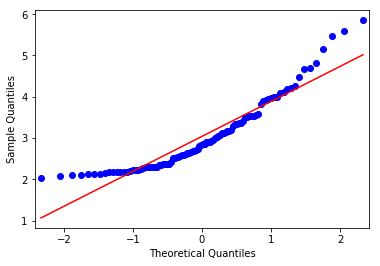

In [7]:
sample = sps.gamma.rvs(1,2,size=100)
sm.qqplot(sample, line='r')
plt.show()

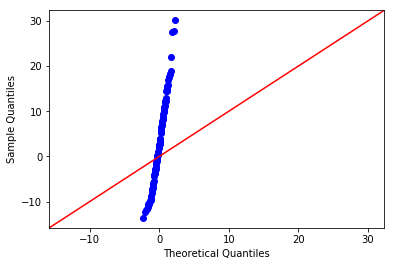

In [139]:
sample = sps.norm(2, 10).rvs(size=100)
sm.qqplot(sample, line='45')
plt.show()

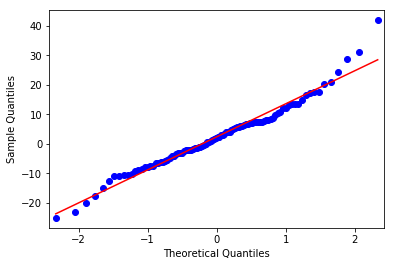

In [140]:
sample = sps.norm(2, 10).rvs(size=100)
sm.qqplot(sample, line='r')
plt.show()

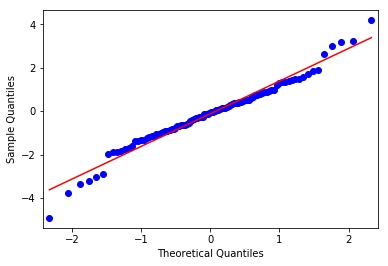

In [143]:
sample = sps.laplace.rvs(size=100)
sm.qqplot(sample, line='r')
plt.show()

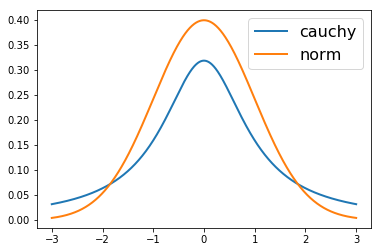

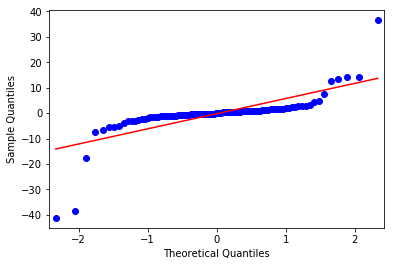

In [245]:
grid = np.linspace(-3, 3, 1000)
plt.plot(grid, sps.cauchy.pdf(grid), lw=2, label='cauchy')
plt.plot(grid, sps.norm.pdf(grid), lw=2, label='norm')
plt.legend(fontsize=16)
plt.show()

sample = sps.cauchy.rvs(size=100)
sm.qqplot(sample, line='r')
plt.show()

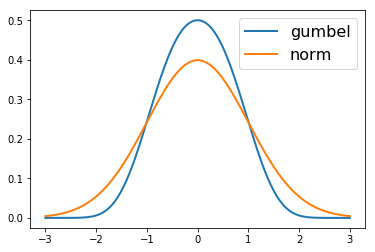

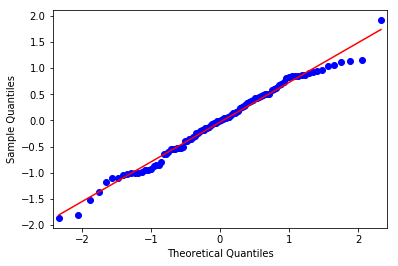

In [242]:
grid = np.linspace(-3, 3, 1000)
plt.plot(grid, sps.gompertz(c=1).pdf(np.abs(grid))/2, lw=2, label='gumbel')
plt.plot(grid, sps.norm.pdf(grid), lw=2, label='norm')
plt.legend(fontsize=16)
plt.show()

sample = sps.gompertz(c=1).rvs(size=100) * (2 * sps.bernoulli(0.5).rvs(size=100) - 1)
sm.qqplot(sample, line='r')
plt.show()

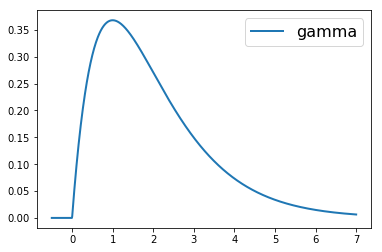

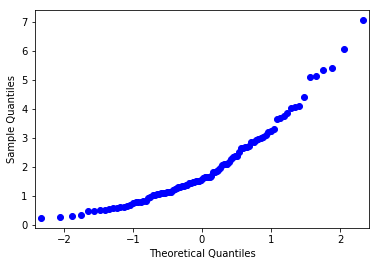

In [254]:
grid = np.linspace(-0.5, 7, 1000)
plt.plot(grid, sps.gamma(a=2).pdf(grid), lw=2, label='gamma')
plt.legend(fontsize=16)
plt.show()

sample = sps.gamma(a=2).rvs(size=100)
sm.qqplot(sample)
plt.show()

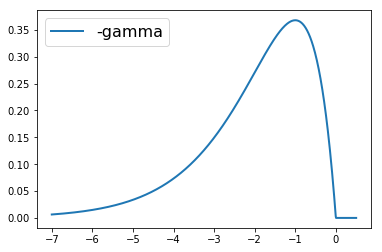

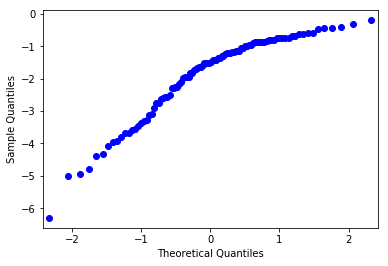

In [257]:
grid = np.linspace(-7, 0.5, 1000)
plt.plot(grid, sps.gamma(a=2).pdf(-grid), lw=2, label='-gamma')
plt.legend(fontsize=16)
plt.show()

sample = -sps.gamma(a=2).rvs(size=100)
sm.qqplot(sample)
plt.show()

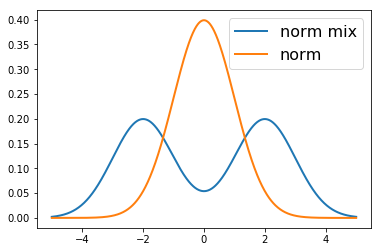

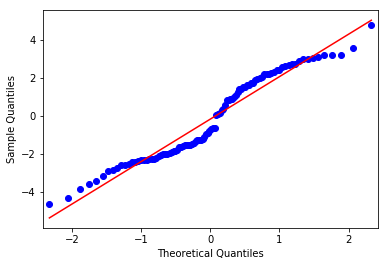

In [266]:
grid = np.linspace(-5, 5, 1000)
plt.plot(grid, (sps.norm(loc=-2).pdf(grid) + sps.norm(loc=2).pdf(grid))/2, lw=2, label='norm mix')
plt.plot(grid, sps.norm.pdf(grid), lw=2, label='norm')
plt.legend(fontsize=16)
plt.show()

bern_sample = sps.bernoulli(0.5).rvs(size=100)
sample = sps.norm(loc=-2).rvs(size=100) * bern_sample + sps.norm(loc=2).rvs(size=100) * (1 - bern_sample)
sm.qqplot(sample, line='r')
plt.show()

### Критерий Шапиро-Уилка

$H_0:$ Выборка из нормального распределения

$H_1: H_0$ не верна.

<a href=https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html#scipy.stats.shapiro>`shapiro`</a>`(x): W, p-value`

In [147]:
sps.shapiro(sps.norm.rvs(size=100))

(0.9915626645088196, 0.788715660572052)

In [149]:
sps.shapiro(sps.norm(20, 100).rvs(size=100))

(0.9933538436889648, 0.9084620475769043)

In [152]:
sps.shapiro(sps.laplace.rvs(size=100))

(0.9767446517944336, 0.07392517477273941)

In [153]:
sps.shapiro(sps.cauchy.rvs(size=100))

(0.5222467184066772, 1.7849432653261265e-16)

### Критерий Жарка-Бера

$H_0:$ Выборка из нормального распределения

$H_1: H_0$ не верна.

<a href=https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.jarque_bera.html#scipy.stats.jarque_bera>`jarque_bera`</a>`(x): jb_value, p-value`

In [158]:
sps.jarque_bera(sps.norm.rvs(size=100))

(0.48701071266555829, 0.78387527732418538)

In [159]:
sps.jarque_bera(sps.norm(20, 100).rvs(size=100))

(0.081229420146787162, 0.96019901369449634)

In [162]:
sps.jarque_bera(sps.laplace.rvs(size=100))

(82.760060584715006, 0.0)

In [163]:
sps.jarque_bera(sps.cauchy.rvs(size=100))

(6637.5391617293171, 0.0)

### Критерий на основе выборочного коэффициента асимметрии

$H_0:$ Выборка из нормального распределения

$H_1: H_0$ не верна.

<a href=https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skewtest.html#scipy.stats.skewtest>`skewtest`</a>`(a): statistic, p-value`

In [165]:
sps.skewtest(sps.norm.rvs(size=100))

SkewtestResult(statistic=-0.44788534043650524, pvalue=0.65423594873651525)

In [167]:
sps.skewtest(sps.norm(20, 100).rvs(size=100))

SkewtestResult(statistic=-0.23872564279470257, pvalue=0.81131833148128563)

In [169]:
sps.skewtest(sps.laplace.rvs(size=100))

SkewtestResult(statistic=-1.0578477348236062, pvalue=0.29012486627456024)

In [174]:
sps.skewtest(sps.cauchy.rvs(size=100))

SkewtestResult(statistic=-1.7028350085528343, pvalue=0.088598949316284398)

In [176]:
sps.skewtest(sps.expon.rvs(size=100))

SkewtestResult(statistic=5.4945514858201738, pvalue=3.9170464063604434e-08)

**Недостаток:** все симметричные распределения признаются нормальными.

**Более правильная формулировка нулевой гипотезы:** коэффициент асимметрии распределения такой же, как и у нормального, то есть равен нулю.